In [ ]:
from transformers import AutoImageProcessor, AutoModel
from PIL import Image
import torch
import os
import numpy as np
from tqdm import tqdm
# 1.  DINOv1
processor = AutoImageProcessor.from_pretrained("facebook/dino-vitb8")
model = AutoModel.from_pretrained("facebook/dino-vitb8")
model.eval()

# 2. extract feature
def extract_feature(img_path):
    try:
        image = Image.open(img_path).convert('RGB').resize((224, 224))
        inputs = processor(images=image, return_tensors="pt")
        with torch.no_grad():
            outputs = model(**inputs)
        return outputs.last_hidden_state.mean(dim=1).squeeze().numpy()
    except Exception as e:
        print(f"[Error] Failed to process {img_path}: {e}")
        return None

# 3. define image folder and extract features
image_folder = r"C:\Users\golds\Desktop\Vectorial Encodings\added image"
features = []
image_names = []

for fname in tqdm(sorted(os.listdir(image_folder))):
    if fname.lower().endswith(('.jpg', '.jpeg', '.png')):
        img_path = os.path.join(image_folder, fname)
        feat = extract_feature(img_path)
        if feat is not None:
            features.append(feat)
            image_names.append(fname)

# 4. save to npy file
features = np.stack(features)
np.save("X_img_dino_vitb8.npy", features)

with open("image_names_dino_vitb8.txt", "w") as f:
    f.write("\n".join(image_names))

print(f"✅ feature extract complete: extract {len(features)} images，dimension {features.shape}")


c:\Users\golds\miniconda3\envs\torch_pig\Lib\site-packages\huggingface_hub\file_download.py:896: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.
c:\Users\golds\miniconda3\envs\torch_pig\Lib\site-packages\transformers\utils\generic.py:311: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(
c:\Users\golds\miniconda3\envs\torch_pig\Lib\site-packages\transformers\utils\generic.py:311: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytr

✅ 特征提取完成：共提取 908 张图像，维度为 (908, 768)


In [4]:
from numba import njit
import numpy as np

class NumbaSOM:
    def __init__(self, x, y, input_len, sigma=6.0, learning_rate=1.0):
        self.x, self.y = x, y
        self.input_len = input_len
        self.sigma = sigma
        self.lr = learning_rate
        self.weights = np.random.rand(x, y, input_len)

    def winner(self, x):
        dists = np.linalg.norm(self.weights - x[None, None, :], axis=2)
        return np.unravel_index(np.argmin(dists), (self.x, self.y))

    def update(self, x, win, iteration, max_iter):
        for i in range(self.x):
            for j in range(self.y):
                dist = np.linalg.norm(np.array([i, j]) - np.array(win))
                influence = np.exp(-dist ** 2 / (2 * self.sigma ** 2))
                lr = self.lr * (1 - iteration / max_iter)
                self.weights[i, j] += lr * influence * (x - self.weights[i, j])

    def train(self, data, num_iteration=100):
        for it in range(num_iteration):
            for x in data:
                win = self.winner(x)
                self.update(x, win, it, num_iteration)



In [ ]:
som = NumbaSOM(x=16, y=16, input_len=X.shape[1], sigma=6.0, learning_rate=1.0)
som.train(X, num_iteration=100)


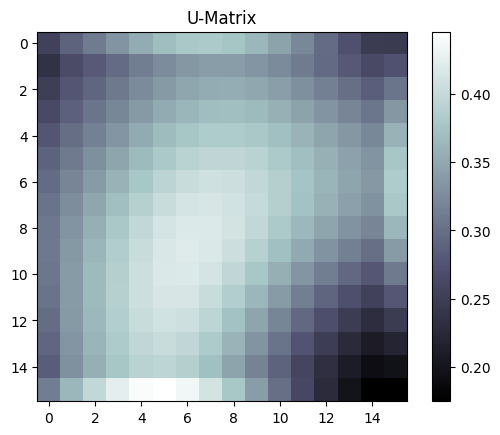

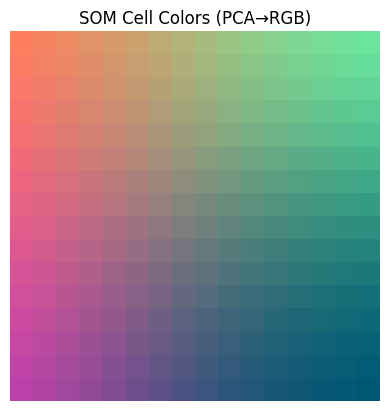

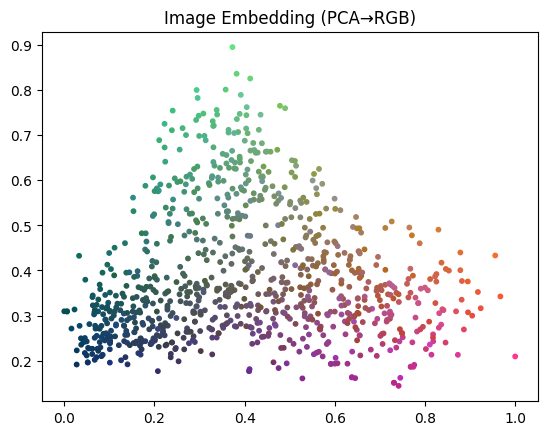

In [ ]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# 1. U-Matrix
umatrix = np.zeros((16, 16))
for i in range(16):
    for j in range(16):
        w = som.weights[i, j]
        dists = []
        for dx, dy in [(-1,0), (1,0), (0,-1), (0,1)]:
            ni, nj = i + dx, j + dy
            if 0 <= ni < 16 and 0 <= nj < 16:
                d = np.linalg.norm(w - som.weights[ni, nj])
                dists.append(d)
        umatrix[i, j] = np.mean(dists)

plt.imshow(umatrix, cmap='bone')
plt.title('U-Matrix')
plt.colorbar()
plt.show()

# 2. PCA→RGB（cell weights）
weights_flat = som.weights.reshape(-1, X.shape[1])
pca = PCA(n_components=3)
rgb_weights = pca.fit_transform(weights_flat)
rgb_weights = (rgb_weights - rgb_weights.min()) / (rgb_weights.max() - rgb_weights.min())  # normalize
rgb_img = rgb_weights.reshape(16, 16, 3)

plt.imshow(rgb_img)
plt.title('SOM Cell Colors (PCA→RGB)')
plt.axis('off')
plt.show()

# 3. PCA→RGB
rgb_data = pca.transform(X)
rgb_data = (rgb_data - rgb_data.min()) / (rgb_data.max() - rgb_data.min())

plt.scatter(rgb_data[:,0], rgb_data[:,1], c=rgb_data, s=10)
plt.title('Image Embedding (PCA→RGB)')
plt.axis('equal')
plt.show()
